#  DengAI: Predicting Disease Spread

Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In this notebook we are going to try to analize the data of the competition of prediction of the data of the Dengue. 
You can get more information from de dataset and the problem in [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

This notebook has been made by:

1.   Agustín Mora Acosta
2.   Andrés González Díaz




# Setting Preliminares

Prior to starting any analysis, it is necessary to ensure that the basic and general purpose libraries (numpy, pandas, etc.) the we are going to use, are correctly imported. 

In [1]:
# Data load and manipulation
from google.colab import files
import io

# DataFrame librery
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tabulate import tabulate

# Basic Operations
import numpy as np
import itertools
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks

# Prepocessing
from sklearn import preprocessing 
from sklearn.impute import KNNImputer

# Models
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy import cluster
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.cluster import DBSCAN



# Data Loading

First of all we load the data into the environment with the functionalities that Google Colab allows us.

In [2]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

The first thing we do is upload the training data without a target field (dengue_features_train). Using pandas library you can explore the data, to set filters and grouping operations. 


In [3]:
train = upload_files(['city', 'weekofyear', 'year'])
train.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


week_start_date  ...  station_precip_mm
city weekofyear year                  ...                   
sj   18         1990      1990-04-30  ...               16.0
     19         1990      1990-05-07  ...                8.6
     20         1990      1990-05-14  ...               41.4
     21         1990      1990-05-21  ...                4.0
     22         1990      1990-05-28  ...                5.8

[5 rows x 21 columns]

In [4]:
train.shape

(1456, 21)

# Preprocessing


Here would go all the functions and transformations that are going to allow the future application of machine learning algorithms, for example the transformation of categorical variables into numerical ones, etc. 
We must be careful in that step to remove redundancy and treat the lost values in the dataset. If we dont do ir properly oir work will be hard in the future, thats is the reason to think all options like how treat the lost values.

In [5]:
train.drop("week_start_date", axis = 1, inplace = True)
train.head()


ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
city weekofyear year                      ...                                       
sj   18         1990  0.122600  0.103725  ...                20.0               16.0
     19         1990  0.169900  0.142175  ...                22.2                8.6
     20         1990  0.032250  0.172967  ...                22.8               41.4
     21         1990  0.128633  0.245067  ...                23.3                4.0
     22         1990  0.196200  0.262200  ...                23.9                5.8

[5 rows x 20 columns]

We are going to see if exist some lost value.

In [6]:
pd.isnull(train).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

We can process them automatically by completing them with the ffill method (with the previous value). If the data is organized chronologically it can be a very fast and useful method. But this time we have chosen to calculate the mean among the five nearest values.

In [7]:
imputer = KNNImputer(n_neighbors=5)
train[:] = imputer.fit_transform(train)

pd.isnull(train).any()

ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

# Filtering

We move on to the filtering stage where we will reduce the datasets to the records with city of origin "San Juan", localizated in the dataset like 'sj'. And the records between 1990 and 1996

In [8]:
train_sj = train.loc['sj']

index_list = []
for i in train_sj.index:
  (_, y) = i
  if y >= 1990 and y <=1996:
    index_list.append(i)
train_filtered = train_sj.loc[index_list]
train_filtered


ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
weekofyear year                      ...                                       
18         1990  0.122600  0.103725  ...                20.0               16.0
19         1990  0.169900  0.142175  ...                22.2                8.6
20         1990  0.032250  0.172967  ...                22.8               41.4
21         1990  0.128633  0.245067  ...                23.3                4.0
22         1990  0.196200  0.262200  ...                23.9                5.8
...                   ...       ...  ...                 ...                ...
48         1996  0.051231  0.103867  ...                22.8               39.5
49         1996 -0.117100 -0.010167  ...                21.7               19.6
50         1996  0.051231  0.049500  ...                20.6                3.1
51         1996  0.051231  0.163900  ...                21.1               25.4
52         1996  0.021400  0.021400  ...                19.4                4.0

[347 rows x 20 columns]


# Dimensionality Reduction

First of all, we are going to extract the correlation among features, to obtain some conclusions. That we make with corrcoef method.

In [9]:
df_features = transpose(train_filtered)
names = df_features.index.values
df_features.head()

weekofyear                   18         19  ...        51        52
year                       1990       1990  ...      1996      1996
ndvi_ne                0.122600   0.169900  ...  0.051231  0.021400
ndvi_nw                0.103725   0.142175  ...  0.163900  0.021400
ndvi_se                0.198483   0.162357  ...  0.170229  0.156975
ndvi_sw                0.177617   0.155486  ...  0.181857  0.147037
precipitation_amt_mm  12.420000  22.820000  ...  0.000000  0.000000

[5 rows x 347 columns]

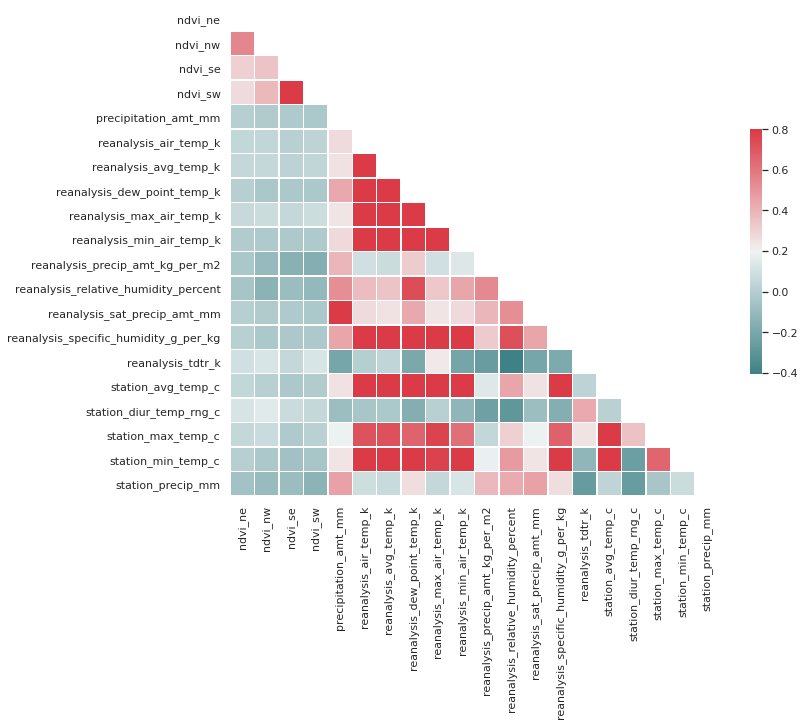

In [10]:
correlation = corrcoef(df_features)

# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

We've obtained the following conclusions from the features analysis:
- The features nvdi_ne, nvdi_nw, nvdi_se, nvdi_sw are slightly correlated between them, but they are not correlated to any other feature. Maybe this features could be reduced in one feature.
-  The features from the reanalysis related to temperature, are strongly correlated between them, and also strongly correlated with other features as station temperature features (station_min_temp_c, station_max_temp_c...) and reanalysis_specific_humidity_g_per_kg.
- The features related to precipitation are highly correlated (precipitation_amt_mm, reanalysis_sat_precip_amt_mm and station_precip_mm)
- The relative humidity percent is inversely correlated with the thermal amplitude (reanalysis_tdtr_k) and the diurn temperature range (station_diur_temp_rng_c).

Normalize data, and execute PCA procedure to reduce dimensionality of the data.



In [11]:
scaler = preprocessing.MinMaxScaler()
dengue_train = scaler.fit_transform(train_filtered)

In [12]:
pca = PCA ()
X_pca = pca.fit_transform(dengue_train)
X_pca.shape

(347, 20)

We show the percentage of variance explained by each of the selected components.

In [13]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"})

We decided to use 3 components to reduce the dimensionality of the data, so we can plot it in a 3D Scatter. This way, we keep almost the 80% of explained variance of the data .

In [14]:
pd.DataFrame(np.matrix.transpose(pca.components_[:3, :]), columns=['PC-1', 'PC-2', 'PC-3'], index=train_filtered.columns)

PC-1      PC-2      PC-3
ndvi_ne                               -0.006489 -0.112419  0.252293
ndvi_nw                               -0.001898 -0.173229  0.326575
ndvi_se                                0.004098 -0.196353  0.562291
ndvi_sw                                0.000529 -0.209070  0.522827
precipitation_amt_mm                  -0.098612  0.383307  0.313354
reanalysis_air_temp_k                 -0.357469 -0.126038 -0.026811
reanalysis_avg_temp_k                 -0.346480 -0.149307 -0.025161
reanalysis_dew_point_temp_k           -0.333703  0.151374  0.032857
reanalysis_max_air_temp_k             -0.287653 -0.177088  0.022519
reanalysis_min_air_temp_k             -0.324640 -0.004525 -0.066580
reanalysis_precip_amt_kg_per_m2       -0.026819  0.150763  0.020462
reanalysis_relative_humidity_percent  -0.152514  0.394626  0.090604
reanalysis_sat_precip_amt_mm          -0.098612  0.383307  0.313354
reanalysis_specific_humidity_g_per_kg -0.349344  0.154469  0.041953
reanalysis_tdtr_k                      0.013798 -0.300207  0.000672
station_avg_temp_c                    -0.360117 -0.132418 -0.076927
station_diur_temp_rng_c                0.018931 -0.286128  0.058258
station_max_temp_c                    -0.252100 -0.244558 -0.025168
station_min_temp_c                    -0.304600  0.000651 -0.112509
station_precip_mm                     -0.023969  0.192642  0.058591

The first component (PC-1) is linearly related with te following features:
  - reanalysis_air_temp_k
  - reanalysis_avg_temp_k
  - reanalysis_dew_point_temp_k
  - reanalysis_max_air_temp_k
  - reanalysis_min_air_temp_k
  - reanalysis_specific_humidity_g_per_kg
  - station_avg_temp_c
  - station_max_temp_c
  - station_min_temp_c

We can say that this component is generally related to the temperature and humidity.

The second component (PC-2) is linearly related with te following features:
  - precipitation_amt_mm
  - reanalysis_relative_humidity_percent
  - reanalysis_sat_precip_amt_mm
  - reanalysis_tdtr_k

We can say that this component is more related to the precipitation, relative humidity and thermal amplitude, but is slightly linearly related with almost al of the features.

The third component (PC-3) is linearly related with te following features:
  - ndvi_ne
  - ndvi_nw
  - ndvi_se
  - ndvi_sw
  - precipitation_amt_mm

We can say that this component is highly related to the vegetation features, but also is related to the precipitation in mm. 

We plot the results.

In [15]:
fig = px.scatter_3d(
    X_pca[:, :3], x=0, y=1, z=2,
    title='Data Visualization by PCA with 3 components',
    labels = {'0':'PCA-1', '1':'PCA-2','2':'PCA-3'}
)
fig.show()

# Outlier Identification

We compute the similarity matrix of the data, and we plot it. We saw that it looked like a chess board, this can be because the weeks are more similar to weeks from the same month/station of other year, than from weeks from the same year but different month/station. This really have sense, and makes a beautiful pattern on the matrix.

In [16]:
# We define euclidean distance as metric for compute the matrix
distance = neighbors.DistanceMetric.get_metric('euclidean')
similarity_matrix = distance.pairwise(dengue_train)

# Plot the matrix
fig = px.imshow(similarity_matrix)
fig.show()

Once we got the similarity matrix, we use DBSCAN to classify the data and identify the outliers. For the parameterization, due to the lack of an expert in the domain, we used the ln(n) heuristic approachOn to set the minPts of the algorithm, where n is the total number of points to be clustered (347 in our case). 

Then, we compute the distance from each point to its neighbors and plot the sorted distance of every point to its kth nearest neighbor, in order to obtain the epsilon parameter for the DBSCAN algorithm.

In [17]:
# We set minPts to ln(347) (Aprox. 6)
minPts=6

# We compute the distance from each point to its neighbors
dist_to_neighbor = neighbors.kneighbors_graph(dengue_train, minPts, include_self=False)
distneigh_array = dist_to_neighbor.toarray()

# We sort the distance of every point to its kth nearest neighbor
seq = []
for i,s in enumerate(dengue_train):
    for j in range(len(dengue_train)):
        if distneigh_array[i][j] != 0:
            seq.append(similarity_matrix[i][j])
            
seq.sort()

# Plot 
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

We choose to try different clusters from 0.5 to 0.8 with intervals of 0.5.

In [18]:
results = []

# Try different clusters with different eps parameter
for eps in np.arange(0.5, 0.8, 0.05):
  db = DBSCAN(eps, min_samples=minPts).fit(dengue_train)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  results.append([eps, n_clusters_, n_outliers])

# We print the results
print(tabulate(results, headers = ("eps", "clusters", "outliers")))

  eps    clusters    outliers
-----  ----------  ----------
 0.5            1          35
 0.55           1          17
 0.6            1          10
 0.65           1           4
 0.7            1           2
 0.75           1           2
 0.8            1           2


We are going to keep the settings that offer a balanced numbre between outliers and groups, so we use 0.65 as eps parameter for the DBSCAN algorithm.

In [19]:
db = DBSCAN(eps=0.65, min_samples=minPts).fit(dengue_train)
labels = db.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

Once we identify outliers, we plot it on a 3D scatter.

In [20]:
 fig = px.scatter_3d(
    X_pca[:, :3], x=0, y=1, z=2,
    color=labels,
    title='Outlier Identification on PCA with 3 components',
    labels = {'0':'PCA-1', '1':'PCA-2','2':'PCA-3'}
)
fig.show()

After identify the outliers, we analyze thy these elements are outliers in order to decide whether or not consider them for further analysis.

In [21]:
# Show data describe for analyzing the outliers
train_filtered.describe()

ndvi_ne     ndvi_nw  ...  station_min_temp_c  station_precip_mm
count  347.000000  347.000000  ...          347.000000         347.000000
mean     0.090668    0.112187  ...           22.586404          24.590047
std      0.080929    0.074536  ...            1.499973          27.823062
min     -0.290200   -0.116267  ...           18.300000           0.000000
25%      0.051231    0.068175  ...           21.700000           6.600000
50%      0.080050    0.101620  ...           22.800000          16.600000
75%      0.121575    0.150962  ...           23.900000          32.450000
max      0.380100    0.437100  ...           25.600000         305.900000

[8 rows x 20 columns]

In [22]:
# Add a new column to the data 
train_filtered['dbscan_group'] = labels

# Show outliers
train_filtered[train_filtered['dbscan_group'] == -1]

ndvi_ne   ndvi_nw  ...  station_precip_mm  dbscan_group
weekofyear year                      ...                                 
21         1992  0.102400  0.068600  ...           22.10000            -1
53         1993  0.142294  0.130553  ...           39.32636            -1
21         1995  0.032200  0.162133  ...           97.50000            -1
38         1996  0.051231  0.028450  ...          305.90000            -1

[4 rows x 21 columns]

We can say the following about each outlier:

- **weekofyear:21 year:1992** - Low satellite vegetation (ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw), with a high total precipitation (precipitation_amt_mm), with a extreme total precipitation reanalysis (reanalysis_precip_amt_kg_per_m2) and a high relative humidity reanalysis (reanalysis_relative_humidity_percent). 

This outlier could be considered outlier because the extreme value in reanalysis_precip_amt_kg_per_m2, which seems like an error in the data because this value does not correspond to the precipitation in mm in the precipitation_amt_mm field.

- **weekofyear:53 year:1993** - Very high maximum air temperature (reanalysis_max_air_temp_k) and low minimum air temperature (reanalysis_min_air_temp_k), with a high relative humidity reanalysis (reanalysis_relative_humidity_percent) and a extreme diurnal temperature range (reanalysis_tdtr_k).

This outlier seems like a week with a great thermal amplitude, but looks factible so well consider this data for further analysis.

- **weekofyear:21 year:1995** - Very high total precipitation reanalysis (precipitation_amt_mm), with a low total precipitation k/m2 reanalysis(reanalysis_precip_amt_kg_per_m2), with a high total precipitation mm reanalysis(reanalysis_sat_precip_amt_mm) and a high total precipitation station measurements (station_precip_mm).

This outlier could be considered outlier because a high value on precipitation_amt_mm and reanalysis_sat_precip_amt_mm but a low value on reanalysis_precip_amt_kg_per_m2. This could be an error in the data so we dont consider this data for further analysis.

- **weekofyear:38 year:1996** - Extreme total precipitation (precipitation_amt_mm), with a high precipitation kg/m2 reanalysis(reanalysis_precip_amt_kg_per_m2), with high relative humidity reanalysis(reanalysis_relative_humidity_percent), with a very high humidity g/kg reanalysis (reanalysis_specific_humidity_g_per_kg), an extreme total precipitation reanalysis (reanalysis_sat_precip_amt_mm) and a (Total precipitation)

This data looks like an extreme rainy week, so we wont consider this data because it can distort data while aplying another clustering algorithm like Hierarchical Clustering Algorithm.


In [23]:
# Remove from data outliers considered

train_filtered = train_filtered.drop([(21, 1992), (21, 1995), (38, 1996)], axis = 0)
train_filtered

ndvi_ne   ndvi_nw  ...  station_precip_mm  dbscan_group
weekofyear year                      ...                                 
18         1990  0.122600  0.103725  ...               16.0             0
19         1990  0.169900  0.142175  ...                8.6             0
20         1990  0.032250  0.172967  ...               41.4             0
21         1990  0.128633  0.245067  ...                4.0             0
22         1990  0.196200  0.262200  ...                5.8             0
...                   ...       ...  ...                ...           ...
48         1996  0.051231  0.103867  ...               39.5             0
49         1996 -0.117100 -0.010167  ...               19.6             0
50         1996  0.051231  0.049500  ...                3.1             0
51         1996  0.051231  0.163900  ...               25.4             0
52         1996  0.021400  0.021400  ...                4.0             0

[344 rows x 21 columns]

In [24]:
# We recompute PCA for this new data
scaler = preprocessing.MinMaxScaler()
dengue_train = scaler.fit_transform(train_filtered)

pca = PCA ()
X_pca = pca.fit_transform(dengue_train)
X_pca.shape

(344, 21)

# Clustering by K-means



The k-means algorithm is based on the idea that a central point can represent a cluster, this point is called centroid. 

Usually this point is the mean or median of a group of points and therefore may not be an element of the set to be analyzed. 

The algorithm
k-means sets a distance between the elements by selecting a predefined number of centroids.

K-means uses these pre-selected centroids as "seeds" in the process of building the clusters. To do so, a cluster is assigned to each centroid, in an iterative process. The cluster assigned to each centroid is the "closest" to it, and the distance is measured between the element to be
included and the average value for all clusters. 

the objective of the k-means algorithm process is to minimize an error or distance function by example, the sum of squared errors.


### Parametrization

In this case we will also choose to cluster on the data projected by PCA.

In [25]:
# parameters
init = 'random' # initialization method 

# to run 20 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 10

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # random seed
random_state = 0

We are going to choose n depending on the values that the clustering takes in terms of Distortion from n = 2 to n = 11. 

In [26]:


distortions = []
silhouettes = []

for i in range(2, 13):
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(X_pca)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(X_pca, labels))

We have to choose approximately the higher Silouehette with the lower Distortion.

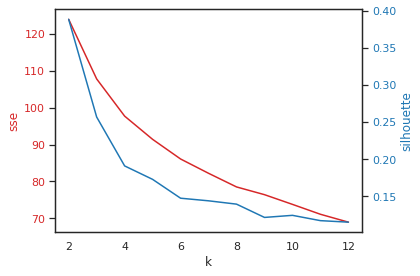

In [27]:

x = [i for i in range(2,13)]
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('sse', color=color)
ax1.plot(x, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
ax2.plot(x, silhouettes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [28]:
#@title Number of clusters {run: "auto"}
k = 3 #@param { type: "slider", min: 2, max: 7, step: 1}

In [29]:
print ("Number of clusters", k)
km = KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km = km.fit_predict(X_pca)

Number of clusters 3


In [30]:
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_pca, y_km))
      
print('Distortion: %.2f' % km.inertia_)

Silhouette Coefficient: 0.257
Distortion: 107.75


The final values of the algorithm metrics and the visualization from the results(assigned group).

In [31]:
km.labels_

array([0, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 2, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0,

And plot the results using the PCA data

In [32]:
fig = px.scatter_3d(
    X_pca[:, :3], x=0, y=1, z=2,
    color = km.labels_,
    title='Label Visualization of k-Means Clustering result',
    labels = {'0':'PCA-1', '1':'PCA-2','2':'PCA-3'}
)
fig.show()

In [33]:
train_filtered['group'] = km.labels_
train_filtered

ndvi_ne   ndvi_nw  ...  dbscan_group  group
weekofyear year                      ...                     
18         1990  0.122600  0.103725  ...             0      0
19         1990  0.169900  0.142175  ...             0      0
20         1990  0.032250  0.172967  ...             0      2
21         1990  0.128633  0.245067  ...             0      1
22         1990  0.196200  0.262200  ...             0      1
...                   ...       ...  ...           ...    ...
48         1996  0.051231  0.103867  ...             0      2
49         1996 -0.117100 -0.010167  ...             0      0
50         1996  0.051231  0.049500  ...             0      0
51         1996  0.051231  0.163900  ...             0      0
52         1996  0.021400  0.021400  ...             0      0

[344 rows x 22 columns]

After visualization, we should make some representation of the data to assign a label to each group, based on the characteristics of each. 

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw
group                                        
0      0.087482  0.112556  0.174977  0.171654
1      0.096126  0.120418  0.178645  0.176913
2      0.087144  0.098699  0.168858  0.161540

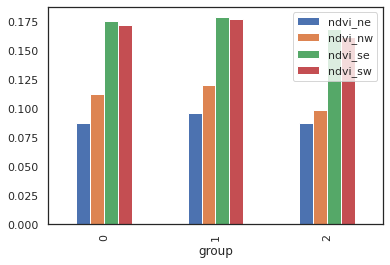

In [34]:
res = train_filtered[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'group']].groupby('group').mean()
res.plot(kind='bar', legend=True)
res

station_precip_mm  ...  reanalysis_sat_precip_amt_mm
group                     ...                              
0              14.379339  ...                      9.031421
1              19.504286  ...                     34.594143
2              43.816221  ...                     58.828896

[3 rows x 4 columns]

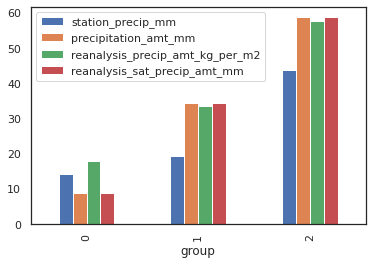

In [35]:
res = train_filtered[['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2','reanalysis_sat_precip_amt_mm', 'group']].groupby('group').mean()
res.plot(kind='bar', legend=True)
res

station_avg_temp_c  station_max_temp_c  station_min_temp_c
group                                                            
0               25.765998           30.766116           21.017355
1               28.423980           33.217143           23.914286
2               27.099622           31.706415           22.627496

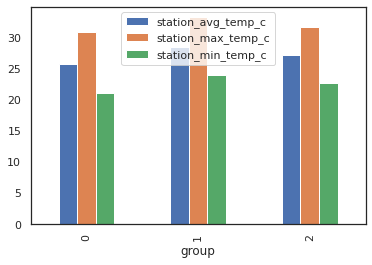

In [36]:
res = train_filtered[['station_avg_temp_c', 'station_max_temp_c',	'station_min_temp_c',	'group']].groupby('group').mean()
res.plot(kind='bar', legend=True)
res

We assigned the following descriptions/labels to the different groups:

- **Group 0 - Low_Precipitation_Temperatures_SlightlyBelow**: Low precipitation and temperatures slightly below average.
- **Group 1 - Standard_Precipitation_Temperatures_Above**: Temperatures above average and standard precipitation. 
- **Group 2 - High_Precipitation_Vegetation_SlightlyBelow**: High precipitation, relative humidity and northwest's vegetation slightly below average.

In [37]:
def get_group_label(g):
  if g == 1:
    return "Standard_Precipitation_Temperatures_Above"
  elif g == 2:
    return "High_Precipitation_Vegetation_SlightlyBelow"
  else :
    return "Low_Precipitation_Temperatures_SlightlyBelow"

train_filtered['group_label'] = train_filtered['group'].apply(lambda x: get_group_label(x))

In [38]:
fig = px.scatter_3d(
    X_pca[:, :3], x=0, y=1, z=2,
    color = train_filtered['group_label'],
    title='Label Visualization of k-Means Clustering result',
    labels = {'0':'PCA-1', '1':'PCA-2','2':'PCA-3'}
)
fig.show()

# Hierarchical Clustering Algorithm

To execute the hierarchical clustering algorithm, we need to compute the similarity matrix. This similarity matrix has been computed previously in 'Outlier identification' section, but we recompute it with the outliers removed from data.

In [39]:
# We define euclidean distance as metric for compute the matrix
distance = neighbors.DistanceMetric.get_metric('euclidean')
similarity_matrix = distance.pairwise(dengue_train)

fig = px.imshow(similarity_matrix)
fig.show()

We executed the hierarchical clustering algorithm, testing different cluster_distances_measures and plotting the resulting dendrogram. 

In our opinion, the best solution is to use complete as linkage criterion as we got concentrated data and this criterion allow us to break up big groups. Using this linkage criterion we get a more balanced dendrogram with 2 small groups.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



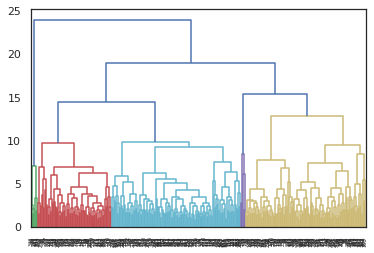

<Figure size 432x288 with 0 Axes>

In [40]:
cut = 13

clusters = cluster.hierarchy.linkage(similarity_matrix, method = 'complete')
dendogram = cluster.hierarchy.dendrogram(clusters, color_threshold=cut)

f = plt.figure()
plt.show()


We've decided to cut this dendrogram by 13, so we get a total of 5 groups, 3 big groups and 2 small groups.

In [41]:
hier_clustering_labels = cluster.hierarchy.fcluster(clusters, cut , criterion = 'distance')

hier_clustering_labels

array([5, 5, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 3, 2, 2, 2, 3, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 5, 3, 3, 5, 5, 1, 3,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 5, 3, 5, 4, 3, 3,
       3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3,
       3, 3, 3, 3, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5,
       5, 3, 3, 5, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 5, 5, 5,
       3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 3, 5, 5, 3, 3, 3, 2,
       3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5,

We can assess the quality of the clustering result using the silohouette coefficien. In this case, this result is not very good, maybe because data is concentrated.

In [42]:
n_clusters_ = len(set(hier_clustering_labels)) - (1 if -1 in hier_clustering_labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(dengue_train, hier_clustering_labels))

Estimated number of clusters: 5
Silhouette Coefficient: 0.145


In [43]:
fig = px.scatter_3d(
    X_pca[:, :3], x=0, y=1, z=2,
    color = hier_clustering_labels,
    title='Data Visualization by PCA with 3 components',
    labels = {'0':'PCA-1', '1':'PCA-2','2':'PCA-3'}
)
fig.show()

Now we've got the best dendrogram/cut in our opinion, we have to characterize the obtained groups. 

For this, we have some representation of the data, which will allow us to assign a label to each group, based on the characteristics of each. 

In [44]:
# Assign clustering labels to data
train_filtered['group'] = hier_clustering_labels

In [45]:
train_filtered.describe()

ndvi_ne     ndvi_nw  ...  dbscan_group       group
count  344.000000  344.000000  ...    344.000000  344.000000
mean     0.090918    0.112412  ...     -0.002907    3.468023
std      0.081190    0.074638  ...      0.053916    1.237943
min     -0.290200   -0.116267  ...     -1.000000    1.000000
25%      0.051231    0.068196  ...      0.000000    3.000000
50%      0.080075    0.102010  ...      0.000000    3.000000
75%      0.121871    0.150494  ...      0.000000    5.000000
max      0.380100    0.437100  ...      0.000000    5.000000

[8 rows x 22 columns]

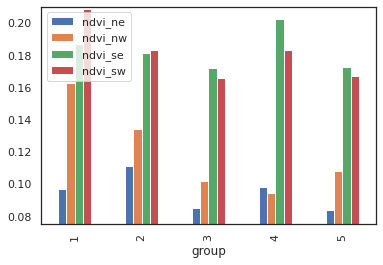

In [46]:
res = train_filtered[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'group']].groupby('group').mean()
res.plot(kind='bar', legend=True, ylim = [0.075,0.210])

In [47]:
res = train_filtered[['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'station_avg_temp_c', 'group']].groupby('group').mean()
res

reanalysis_air_temp_k  ...  station_avg_temp_c
group                         ...                    
1                 296.719184  ...           24.687755
2                 300.122368  ...           28.728008
3                 299.281869  ...           27.664103
4                 298.404942  ...           26.691442
5                 297.724390  ...           25.832404

[5 rows x 6 columns]

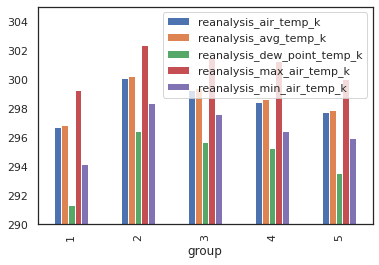

In [48]:
res = train_filtered[['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'group']].groupby('group').mean()
res.plot(kind='bar', legend=True, ylim = [290,305])

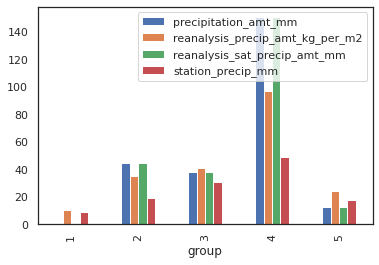

In [49]:
res = train_filtered[['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm', 'group']].groupby('group').mean()
res.plot(kind='bar', legend=True)

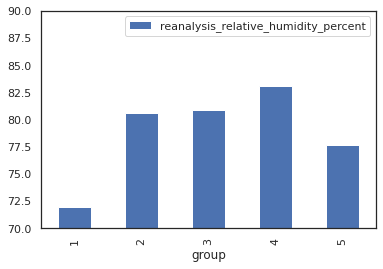

In [50]:
res = train_filtered[['reanalysis_relative_humidity_percent', 'group']].groupby('group').mean()
res.plot(kind='bar', legend=True, ylim=[70, 90])

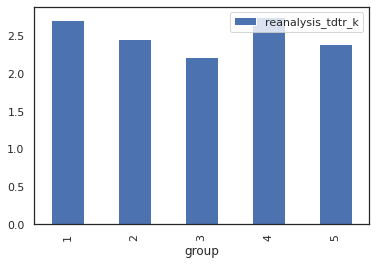

In [51]:
res = train_filtered[['reanalysis_tdtr_k', 'group']].groupby('group').mean()
res.plot(kind='bar', legend=True)


We assigned the following descriptions/labels to the different groups:

- **Group 1 - Low_Precipitation_Temperatures_Below**: Vegetation on the west above average, very low precipitation and temperatures below average.
- **Group 2 - Standard_Precipitation_Temperatures_Above**: Temperatures above average and standard precipitation. 
- **Group 3 - Standard_Precipitation_Temperatures_ThermalAmplitude_Below**: Vegetation and thermal amplitude below average and standard precipitation/temperature.
- **Group 4 - High_Precipitation_RelativeHumidity**: High precipitation and high relative humidity.
- **Group 5 - Low_Precipitation_RelativeHumidity_Below**: Low precipitation and relative humidity below average.

In [52]:
def get_group_label(g):
  if g == 1:
    return "Low_Precipitation_Temperatures_Below"
  elif g == 2:
    return "Standard_Precipitation_Temperatures_Above"
  elif g == 3:
    return "Standard_Precipitation_Temperatures_ThermalAmplitude_Below"
  elif g == 4:
    return "High_Precipitation_RelativeHumidity"
  else:
    return "Low_Precipitation_RelativeHumidity_Below"

train_filtered['group_label'] = train_filtered['group'].apply(lambda x: get_group_label(x))

Plot the graphical result of the clustering, with the labels assigned to the groups.

In [53]:
fig = px.scatter_3d(
    X_pca[:, :3], x=0, y=1, z=2,
    color = train_filtered['group_label'],
    title='Label Visualization of Hierarchical Clustering result',
    labels = {'0':'PCA-1', '1':'PCA-2','2':'PCA-3'}
)
fig.show()